In [8]:
import pandas as pd
import os
from striprtf.striprtf import rtf_to_text

In [9]:
file_names = os.listdir('../SleepMeditations/')
# Create Dictionary for File Name and Text
file_name_and_text = {}
for file in file_names:
    if (file == ".ipynb_checkpoints"):
        continue

    with open('../SleepMeditations/' + file, "r",
             encoding='unicode_escape') as infile:
        content = infile.read()
        text = rtf_to_text(content)
        file_name_and_text[file] = text
file_data = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
             .reset_index().rename(index=str, columns={'index': 'file_name', 0: 'text'}))

file_data

,file_name,text
0,Sleep - 33.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
1,Sleep - 32.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
2,Sleep - 26.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
3,Sleep - 18.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
4,Sleep - 30.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
...,...,...
108,Sleep - 116.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
109,Sleep -16.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
110,Sleep - 102.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...
111,Sleep - 103.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...


In [10]:
import math
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anushree/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
from nltk.corpus import stopwords
en_stop_words = set(stopwords.words('english'))
list(en_stop_words)[:10]

def clean_tweets(df=file_data, 
                 text_col='text', 
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # format the date
    #df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%m-%d-%Y %H:%M:%S'))
    
    # filter rows older than a given date
    #df_copy = df_copy[df_copy[date_col] >=start_datetime]
    
    # lower the tweets
    df_copy['preprocessed_' + text_col] = df_copy[text_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    en_stop_words.add('music')
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt',                           
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + text_col] = df_copy['preprocessed_' + text_col].apply(lambda row: ' '.join(
        [word for word in row.split() if (not word in en_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + text_col] = df_copy['preprocessed_' + text_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy

#df_tweets = pd.read_csv('trump_tweets.csv')
df_clean = clean_tweets(file_data)
df_clean.head()

,file_name,text,preprocessed_text,tokenized_text
0,Sleep - 33.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...,tf1nsinsicpg1252 onttbl 0 nil charset0 helve...,"[tf1, nsi, nsicpg1252, onttbl, nil, charset0, ..."
1,Sleep - 32.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...,tf1nsinsicpg1252 onttbl 0 nil charset0 helve...,"[tf1, nsi, nsicpg1252, onttbl, nil, charset0, ..."
2,Sleep - 26.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...,tf1nsinsicpg1252 onttbl 0 nil charset0 helve...,"[tf1, nsi, nsicpg1252, onttbl, nil, charset0, ..."
3,Sleep - 18.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...,tf1nsinsicpg1252 onttbl 0 nil charset0 helve...,"[tf1, nsi, nsicpg1252, onttbl, nil, charset0, ..."
4,Sleep - 30.rtf,tf1nsinsicpg1252 onttbl 0 nil charset0 Helve...,tf1nsinsicpg1252 onttbl 0 nil charset0 helve...,"[tf1, nsi, nsicpg1252, onttbl, nil, charset0, ..."


In [12]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0) 
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for line in df_clean.tokenized_text for word in line],10)

[('music', 8049),
 ('body', 2106),
 ('feel', 1206),
 ('mind', 1185),
 ('breath', 1127),
 ('let', 1098),
 ('go', 1065),
 ('sleep', 895),
 ('allow', 770),
 ('love', 758)]

Text(0, 0.5, 'Coherence Score')

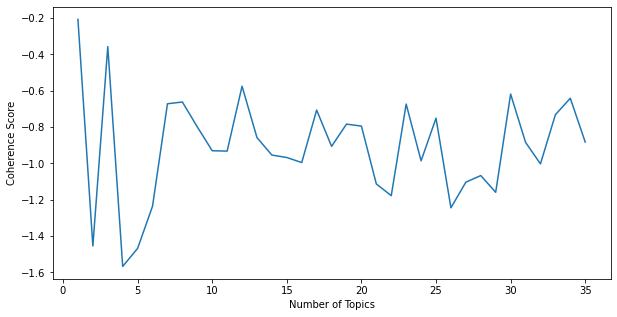

In [13]:
import matplotlib.pyplot as plt
# build a dictionary where for each tweet, each word has its own id.
# We have 6882 tweets and 10893 words in the dictionary.
tweets_dictionary = Dictionary(df_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(
    tweet) for tweet in df_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1, 36):
    lda = LdaModel(tweets_corpus, num_topics=nb_topics,
                   id2word=tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus,
                          dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10, 5))
plt.plot(range(1, 36), tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")



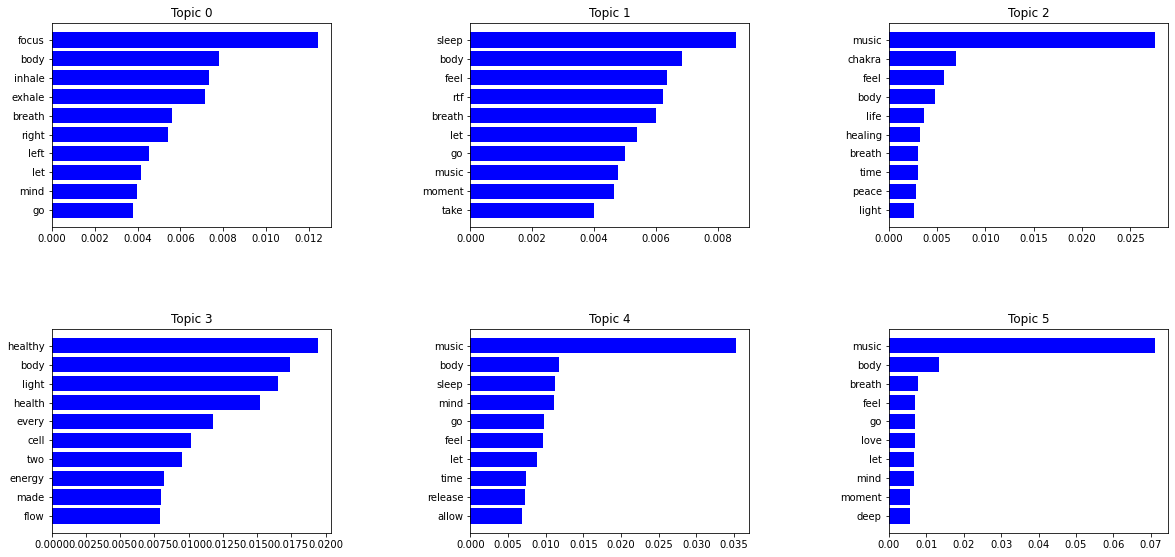

In [14]:
import matplotlib.gridspec as gridspec

k = 6
tweets_lda = LdaModel(tweets_corpus, num_topics=k,
                      id2word=tweets_dictionary, passes=10)


def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word, _ in lda.show_topic(
        topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _, beta in lda.show_topic(
        topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs = gridspec.GridSpec(round(math.sqrt(k))+1, round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20, 15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words],
                 align='center', color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))


plot_top_words()